<img src="../images/full-jtech-d-15-0020_1-f4.jpg" width=700 alt="QVP plot"></img>

Courtesy: Rizhkov, et al. (2014)

# Quasy-Vertical Profile 

---

In [1]:
import xarray as xr
import cmweather
import numpy as np
from dask.distributed import Client, LocalCluster
import hvplot.xarray
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import cm

xr.__version__

'2024.10.1.dev59+g700191b9'

In [2]:
cluster = LocalCluster(
    dashboard_address="127.0.0.1:8785",
)
client = Client(cluster)

In [3]:
path = "../zarr/KVNX.zarr"

In [4]:
%%time
dtree = xr.open_datatree(
    path,
    engine="zarr",
    consolidated=True,
    chunks={},
)

CPU times: user 1.85 s, sys: 560 ms, total: 2.42 s
Wall time: 3.35 s


In [5]:
list(dtree.children)

['VCP-11', 'VCP-12', 'VCP-212']

In [6]:
list(dtree["VCP-12"].children)

['georeferencing_correction',
 'radar_calibration',
 'radar_parameters',
 'sweep_0',
 'sweep_1',
 'sweep_10',
 'sweep_11',
 'sweep_12',
 'sweep_13',
 'sweep_14',
 'sweep_15',
 'sweep_16',
 'sweep_2',
 'sweep_3',
 'sweep_4',
 'sweep_5',
 'sweep_6',
 'sweep_7',
 'sweep_8',
 'sweep_9']

In [7]:
ds_qvp = dtree["/VCP-12/sweep_16"].ds.sel(vcp_time=slice("2011-05-20 10:00","2011-05-20 12:00"))

In [8]:
def compute_qvp(ds: xr.Dataset, var="reflectivity")-> xr.DataArray:
    """
    Computes a Quasi-Vertical Profile (QVP) from a radar time-series dataset.
    
    This function averages the specified variable over the azimuthal dimension
    to produce a QVP. If the variable is in dBZ (a logarithmic scale), it converts
    the values to linear units before averaging and then converts the result 
    back to dBZ.
    
    Parameters:
    -----------
    ds : xr.Dataset
        The Xarray Dataset containing the radar data. This dataset should include
        multiple sweeps, azimuth angles, and range gates.
    var : str, optional
        The variable to be averaged to create the QVP. 
        Default is "reflectivity".
    
    Returns:
    --------
    xr.DataArray
        A DataArray representing the QVP for the specified variable. The result
        is averaged over azimuth and adjusted for height using the mean sweep 
        elevation angle.
    
    """
    
    units: str = ds[var].attrs['units']
    if units.startswith("dB"):
        qvp = 10 ** (ds[var] / 10)
        qvp = qvp.mean("azimuth", skipna=True)
        qvp = 10 * np.log10(qvp)
    else:
        qvp = ds[var]
        qvp = qvp.mean("azimuth", skipna=True)

    # computing heigth dimension
    qvp = qvp.assign_coords({"range":(qvp.range.values * 
                                 np.sin(
                                     ds.sweep_fixed_angle.mean(skipna=True).values *  
                                        np.pi / 180.)) /1000})

    qvp = qvp.rename(f"qvp_{var}")
    qvp = qvp.rename({"range": "height"})
    return qvp

In [9]:
ds_qvp = dtree["/VCP-12/sweep_16"].ds.sel(vcp_time=slice("2011-05-20 09:45","2011-05-20 12:15"))

In [10]:
qvp_ref = compute_qvp(ds_qvp, var="DBZH")

In [11]:
qvp_zdr = compute_qvp(ds_qvp, var="ZDR")
qvp_rhohv = compute_qvp(ds_qvp, var="RHOHV")
qvp_phidp = compute_qvp(ds_qvp, var="PHIDP")

CPU times: user 2.78 s, sys: 103 ms, total: 2.89 s
Wall time: 3.35 s


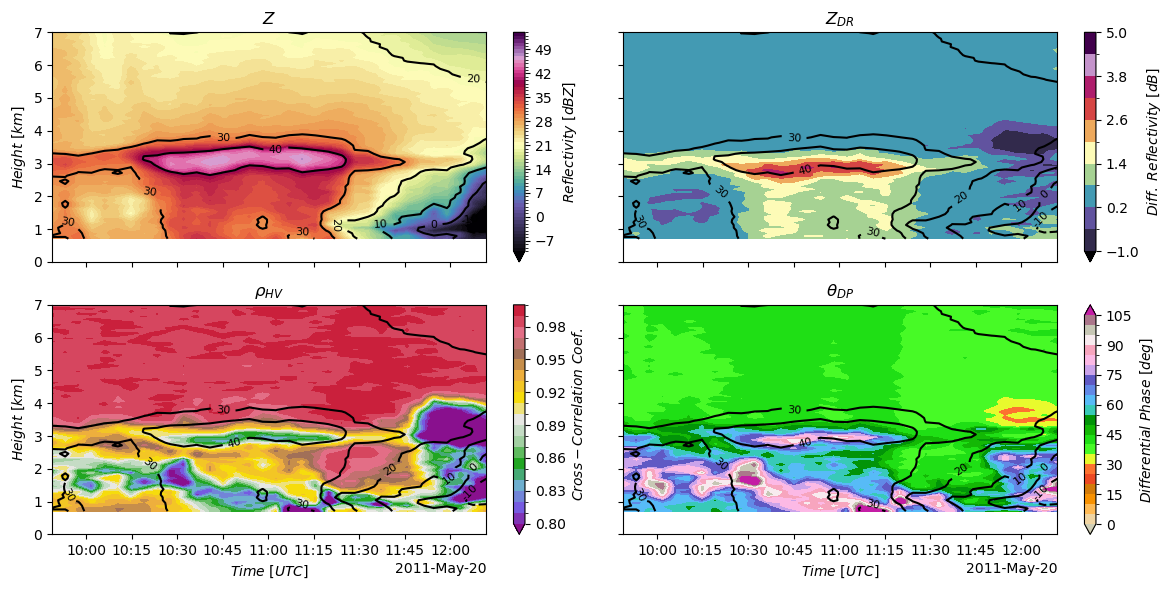

In [12]:
%%time
fig, axs = plt.subplots(2, 2, figsize=(12, 6), sharey=True, sharex=True)

## Reflectivity plot
cf = qvp_ref.plot.contourf(
    x="vcp_time",
    y="height",
    cmap="ChaseSpectral",
    levels=np.arange(-10, 55, 1),
    ax=axs[0][0],
    add_colorbar=False,
)
contour_lines = qvp_ref.plot.contour(
    x="vcp_time",
    y="height",
    colors="k",  # Black contour lines
    levels=np.arange(-10, 50, 10),  # Contour lines every 10 units
    ax=axs[0][0],
)
axs[0][0].clabel(contour_lines, fmt='%d', inline=True, fontsize=8)

axs[0][0].set_title(r"$Z$")
axs[0][0].set_xlabel("")
axs[0][0].set_ylabel(r"$Height \ [km]$")
axs[0][0].set_ylim(0,7)

cbar = plt.colorbar(cf, ax=axs[0][0], 
                    label=r"$Reflectivity \ [dBZ]$", 
                   )
## ZDR plot
cf1 = qvp_zdr.plot.contourf(
    x="vcp_time",
    y="height",
    cmap="ChaseSpectral",
    ax=axs[0][1],
    levels=np.linspace(-1, 5, 11),
    add_colorbar=False,
)

contour_lines = qvp_ref.plot.contour(
    x="vcp_time",
    y="height",
    colors="k",  # Black contour lines
    levels=np.arange(-10, 50, 10),  # Contour lines every 10 units
    ax=axs[0][1],
)
axs[0][1].clabel(contour_lines, fmt='%d', inline=True, fontsize=8) 

axs[0][1].set_title(r"$Z_{DR}$")
axs[0][1].set_xlabel("")
axs[0][1].set_ylabel(r"")

cbar = plt.colorbar(cf1, ax=axs[0][1], 
                    label=r"$Diff. \ Reflectivity \ [dB]$", 
                   )

### RHOHV plot
cf2 = qvp_rhohv.plot.contourf(
    x="vcp_time",
    y="height",
    cmap="Carbone11",
    ax=axs[1][0],
    levels=np.arange(0.8, 1.01, 0.01),
    add_colorbar=False,
)

contour_lines = qvp_ref.plot.contour(
    x="vcp_time",
    y="height",
    colors="k",  # Black contour lines
    levels=np.arange(-10, 50, 10),  # Contour lines every 10 units
    ax=axs[1][0],
)
axs[1][0].clabel(contour_lines, fmt='%d', inline=True, fontsize=8)

axs[1][0].set_title(r"$\rho _{HV}$")
axs[1][0].set_ylabel(r"$Height \ [km]$")
axs[1][0].set_xlabel(r"$Time \ [UTC]$")

cbar = plt.colorbar(cf2, ax=axs[1][0], 
                    label=r"$Cross-Correlation \ Coef.$", 
                   )

### PHIDP
cf3 = qvp_phidp.plot.contourf(
    x="vcp_time",
    y="height",
    cmap="PD17",
    ax=axs[1][1],
    levels=np.arange(0, 110, 5),
    add_colorbar=False,

)

contour_lines = qvp_ref.plot.contour(
    x="vcp_time",
    y="height",
    colors="k",  # Black contour lines
    levels=np.arange(-10, 50, 10),  # Contour lines every 10 units
    ax=axs[1][1],
)
axs[1][1].clabel(contour_lines, fmt='%d', inline=True, fontsize=8)

axs[1][1].set_title(r"$\theta _{DP}$")
axs[1][1].set_xlabel(r"$Time \ [UTC]$")
axs[1][1].set_ylabel(r"")

cbar = plt.colorbar(cf3, ax=axs[1][1], 
                    label=r"$Differential \ Phase \ [deg]$", 
                   )

fig.tight_layout()


## References

* Ryzhkov, A., P. Zhang, H. Reeves, M. Kumjian, T. Tschallener, S. Trömel, and C. Simmer, 2016: Quasi-Vertical Profiles—A New Way to Look at Polarimetric Radar Data. J. Atmos. Oceanic Technol., 33, 551–562, https://doi.org/10.1175/JTECH-D-15-0020.1.